In [26]:
from pathlib import Path

import numpy as np
import pypulseq as pp
from bmc.utils.seq.write import write_seq

import matplotlib.pyplot as plt

In [27]:
try:
    seqid = Path(__file__).stem + "_python"
    folder = Path(__file__).parent
except NameError:
    seqid = "simple_gauss_gradient"
    folder = Path(".")

In [28]:
# general settings
AUTHOR = "DANIEL MIKSCH"
FLAG_PLOT_SEQUENCE = True  # plot preparation block?
FLAG_CHECK_TIMING = True  # perform a timing check at the end of the sequence?
FLAG_POST_PREP_SPOIL = True  # add spoiler after preparation block?

# sequence definitions
defs: dict = {}
defs["a"] = 90 # a in degrees
defs["b0"] = 17  # B0 [T]

# defs["trec_m0"] = 12  # recovery time before M0 [s]
defs["m0_offset"] = 0  # m0 offset [ppm]
defs["offsets_ppm"] = np.array([defs["m0_offset"]])

defs["num_meas"] = defs["offsets_ppm"].size  # number of repetition

defs["seq_id_string"] = seqid  # unique seq id


seq_filename = defs["seq_id_string"] + ".seq"

In [29]:
sys = pp.Opts(
    max_grad=1250,
    grad_unit="mT/m",
    max_slew=1000,
    slew_unit="T/m/s",
    rf_ringdown_time=0,
    rf_dead_time=0,
    rf_raster_time=1e-6,
    gamma=42576400,
    grad_raster_time=1e-6,
)

GAMMA_HZ = sys.gamma * 1e-6
defs["freq"] = defs["b0"] * GAMMA_HZ  # Larmor frequency [Hz]
GAMMA_HZ

42.5764

In [30]:
# ===========
# PREPARATION
# ===========


# rf pulse
flip_angle = np.radians(defs['a'])
t_pulse = 10e-3
# bandwidth_read = 

rf_90 = pp.make_gauss_pulse(
    flip_angle=flip_angle,
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

spoil_amp = 0.1 * sys.max_grad  # Hz/m
rise_time = 1e-3#(spoil_amp / GAMMA_HZ) / sys.max_slew  # spoiler rise time in seconds
spoil_dur = 500e-3  # complete spoiler duration in seconds


def create_trapezoid(amplitude, duration, rise_time, dt=sys.grad_raster_time):
    if 2 * rise_time > duration:
        raise ValueError("Die Anstiegs- und Abfallzeit zusammen dürfen nicht länger als die Gesamtdauer sein.")

    # Anzahl der Samples für jede Phase
    num_rise_samples = int(rise_time / dt)  # Anzahl der Samples für die Anstiegsphase
    num_flat_samples = int((duration - 2 * rise_time) / dt)  # Anzahl der Samples für das Plateau
    total_samples = num_rise_samples * 2 + num_flat_samples  # Gesamte Anzahl der Samples

    # Trapezoid erstellen
    trapezoid = np.zeros(total_samples)

    # Anstiegsphase: Linear von 0 bis zur Amplitude
    rise = np.linspace(0, amplitude, num_rise_samples, endpoint=False)
    trapezoid[:num_rise_samples] = rise

    # Plateau: Konstante Amplitude
    trapezoid[num_rise_samples:num_rise_samples + num_flat_samples] = amplitude

    # Abfallphase: Linear von Amplitude zurück auf 0
    fall = np.linspace(amplitude, 0, num_rise_samples, endpoint=True)
    trapezoid[num_rise_samples + num_flat_samples:] = fall

    return trapezoid

trapeziod = create_trapezoid(spoil_amp, spoil_dur, rise_time)

gz_spoil = pp.make_arbitrary_grad(channel='z', 
                             system=sys, 
                             waveform=trapeziod,
                             )


#pseudo adc
pseudo_adc = pp.make_adc(num_samples=1, duration=1e-3)


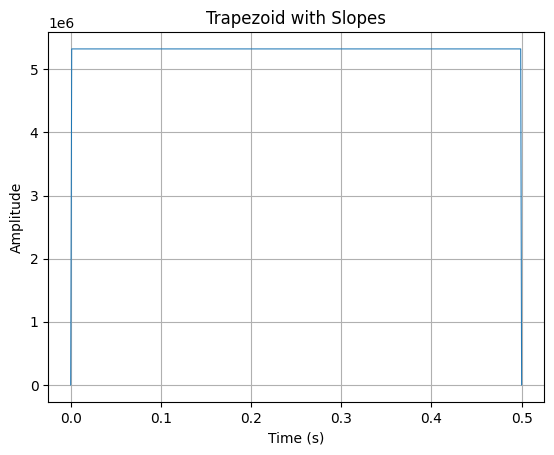

5322050.0

In [31]:
      # Anstiegszeit (20 ms)
             # Zeitauflösung (1 ms)
dt = sys.grad_raster_time  # Zeitauflösung

# Trapezoid erzeugen
trapezoid = create_trapezoid(spoil_amp, spoil_dur, rise_time, dt)

# Plot
import matplotlib.pyplot as plt
time = np.arange(len(trapezoid)) * dt  # Zeitachse
plt.plot(time, trapezoid)
plt.title("Trapezoid with Slopes")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()
spoil_amp

In [32]:
seq = pp.Sequence()

offsets_hz = defs["offsets_ppm"] * defs["freq"]  # convert from ppm to Hz

In [33]:

rf_90.freq_offset = 0

seq.add_block(rf_90)
seq.add_block(gz_spoil)
seq.add_block(rf_90)
seq.add_block(pseudo_adc)

if FLAG_CHECK_TIMING:
    ok, error_report = seq.check_timing()
if ok:
    print("\nTiming check passed successfully")
else:
    print("\nTiming check failed! Error listing follows\n")
    print(error_report)


Timing check passed successfully


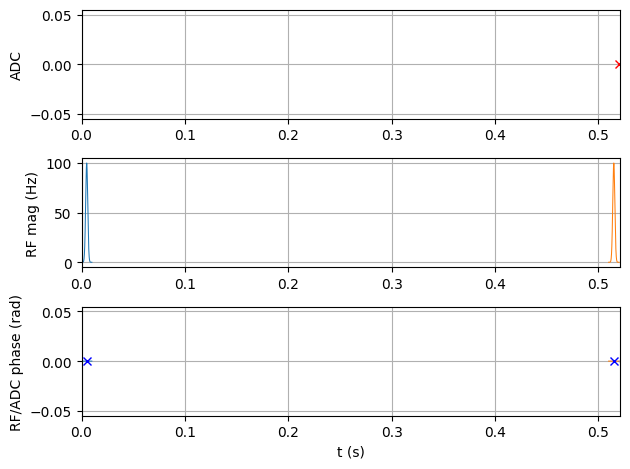

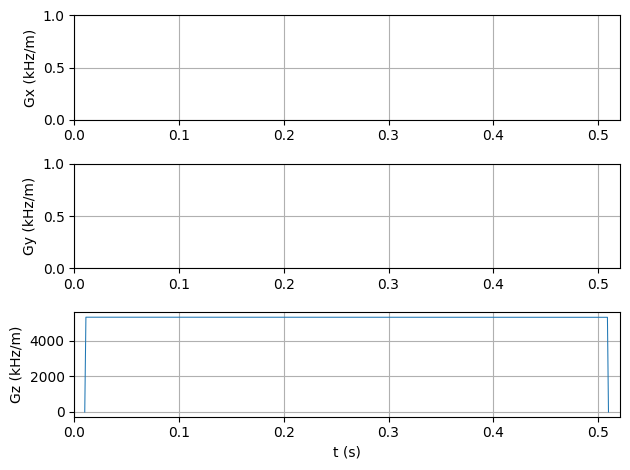

In [34]:
if FLAG_PLOT_SEQUENCE:
    seq.plot() #time_range=[0.00, .03]

In [35]:
write_seq(seq=seq, seq_defs=defs, filename=folder / seq_filename, author=AUTHOR, use_matlab_names=True)

In [36]:
pp.calc_duration(rf_90)

0.01

In [37]:
np.radians(360)

6.283185307179586